In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression,LogisticRegression


# All plots can be displayed on notebooks:
%matplotlib inline

# Make better use of Jupyter Notebook cell width

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))
pd.options.display.float_format = '{:.2f}'.format

In [2]:
#!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

In [3]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv.1')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [6]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [7]:
model = LogisticRegression(solver='liblinear', random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [8]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [9]:
small_subset = ['contract', 'tenure', 'totalcharges']
train_dict_small = df_train[small_subset].to_dict(orient='records')
dv_small = DictVectorizer(sparse=False)
dv_small.fit(train_dict_small)

X_small_train = dv_small.transform(train_dict_small)

model_small = LogisticRegression(solver='liblinear', random_state=1)
model_small.fit(X_small_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [10]:
val_dict_small = df_val[small_subset].to_dict(orient='records')
X_small_val = dv_small.transform(val_dict_small)

y_pred_small = model_small.predict_proba(X_small_val)[:, 1]


In [11]:
y_pred = model.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8055358410220014

# Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
len(y_val)

1409

In [14]:
accuracy_score(y_val, y_pred >= 0.5)

0.8055358410220014

In [15]:
thresholds = np.linspace(0,1,11)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [16]:
# Checking alternative thresholds:

In [17]:
thresholds = np.linspace(0, 1, 21)

accuracies = []

for t in thresholds:
    acc = accuracy_score(y_val, y_pred >= t)
    accuracies.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.274
0.05 0.508
0.10 0.605
0.15 0.664
0.20 0.705
0.25 0.738
0.30 0.759
0.35 0.767
0.40 0.781
0.45 0.793
0.50 0.806
0.55 0.804
0.60 0.800
0.65 0.787
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


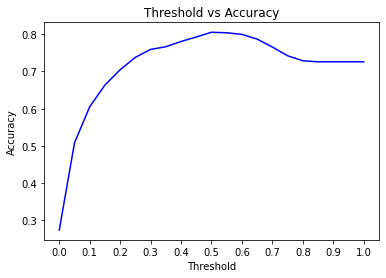

In [18]:
plt.figure(figsize=(6, 4))

plt.plot(thresholds, accuracies, color='blue')

plt.title('Threshold vs Accuracy')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.xticks(np.linspace(0, 1, 11))

# plt.savefig('04_threshold_accuracy.svg')

plt.show()

In [19]:
from collections import Counter

In [20]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

# Confusion table:
- Different types of errors and correct decisions
- Arranging them in a table

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
actual_positive

array([False, False, False, ..., False,  True,  True])

In [23]:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [24]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [25]:
fp,fn,tp,tn

(100, 174, 212, 923)

In [26]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[923, 100],
       [174, 212]])

In [27]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.66, 0.07],
       [0.12, 0.15]])

# Precision and Recall

In [28]:
# Precision: Fraction of positive predictions are correct

In [29]:
p = tp / (tp + fp)
p

0.6794871794871795

In [30]:
# Recall: Fraction of correctly identified positive examples

In [31]:
r = tp / (tp + fn)
r

0.5492227979274611

In [32]:
# ROC(receiver operating characteristic) curves:

In [33]:
#True Positive rate
tpr = tp / (tp + fn) # Equals to recall
tpr

0.5492227979274611

In [34]:
#False Positive rate
fpr = fp / (fp + tn)
fpr

0.09775171065493646

In [35]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [36]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

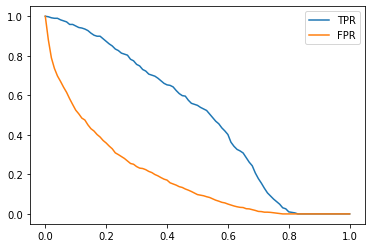

In [37]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

In [38]:
# Random Model

In [39]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [40]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [41]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [42]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

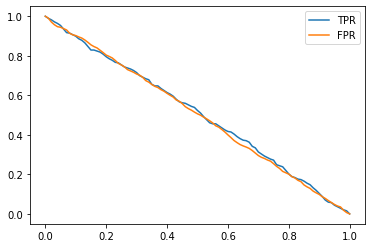

In [43]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()


# Ideal model

In [44]:
number_neg = (y_val == 0).sum()
number_pos = (y_val == 1).sum()
number_neg,number_pos

(1023, 386)

In [45]:
y_ideal = np.repeat([0,1],[number_neg,number_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [46]:
y_ideal = np.repeat([0, 1], [number_neg, number_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [47]:
1 - y_val.mean()

0.7260468417317246

In [48]:
accuracy_score(y_ideal, y_ideal_pred >= 0.738)

0.9879347054648687

In [49]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.00,1.00
10,0.10,386,882,0,141,1.00,0.86
20,0.20,386,741,0,282,1.00,0.72
30,0.30,386,600,0,423,1.00,0.59
40,0.40,386,459,0,564,1.00,0.45
50,0.50,386,319,0,704,1.00,0.31
60,0.60,386,178,0,845,1.00,0.17
70,0.70,386,37,0,986,1.00,0.04
80,0.80,282,0,104,1023,0.73,0.00
90,0.90,141,0,245,1023,0.37,0.00


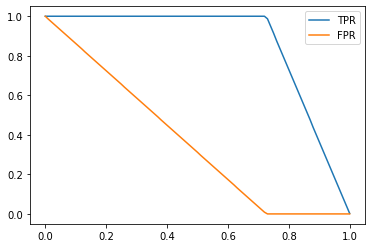

In [50]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

# Putting everything together:

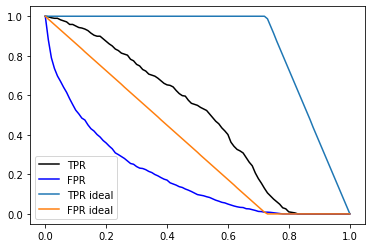

In [51]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

#plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
#plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

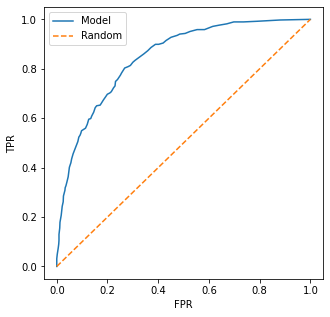

In [52]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [53]:
from sklearn.metrics import roc_curve

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [55]:
# Below grapg is more accurate than above(sklearn more use thresholds):

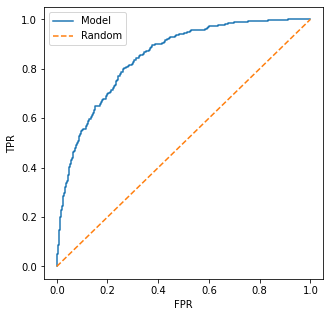

In [56]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

# ROC AUC
- Area under roc curve - useful metric
- Interpretation of AUC

In [57]:
from sklearn.metrics import auc

In [58]:
auc(fpr,tpr)

0.8465981898206534

In [59]:
auc(df_scores.fpr,df_scores.tpr)

0.8463208889834327

In [60]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [61]:
fp, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr )

0.8465981898206534

In [62]:
from sklearn.metrics import roc_auc_score

In [63]:
roc_auc_score(y_val, y_pred)

0.8465981898206534

In [64]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [65]:
import random

In [66]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84903

In [67]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84892

# Cross - Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [68]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [69]:
#dv, model = train(df_train, y_train, C=0.001)

In [70]:
dv, model

(DictVectorizer(sparse=False),
 LogisticRegression(random_state=1, solver='liblinear'))

In [71]:
def predict(df, dvi, model):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [72]:
#y_pred = predict(df_val,dv,model)

In [73]:
from sklearn.model_selection import KFold

In [74]:
from tqdm.auto import tqdm

In [75]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

ValueError: Found input variables with inconsistent numbers of samples: [1127, 4507]